In [6]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
# !pip install pennylane
import time
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1709263591.434002
Thu Feb 29 20:26:31 2024


In [8]:
from pennylane import broadcast
import torch
from torch.utils.data import DataLoader, TensorDataset
import jax
from jax import numpy as jnp
from jax import random
import numpy as np
import optax

In [9]:
def digits2position(vec_of_digits, n_positions):
        """One-hot encoding of a batch of vectors. """
        return torch.tensor(np.eye(n_positions)[vec_of_digits])

def position2digit(exp_values):
        """Inverse of digits2position()."""
        return np.argmax(exp_values)

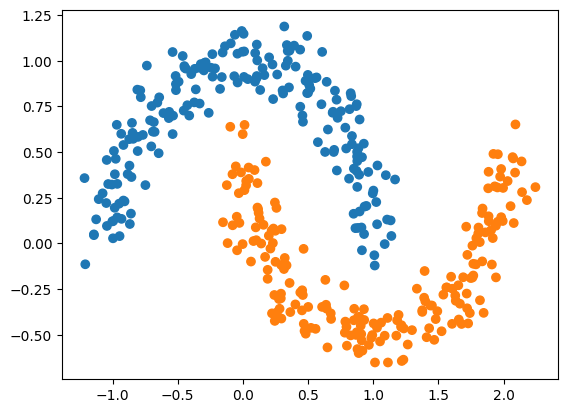

In [10]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Set random seeds
torch.manual_seed(149)
random.PRNGKey(149)

X, y = make_moons(n_samples=400, noise=0.1)
X = jnp.array(X)
y = jnp.array(y)
y_hot = digits2position(y, 2)
# y_ = torch.unsqueeze(torch.tensor(y), 1)  # used for one-hot encoded labels
# y_hot = torch.scatter(torch.zeros((400, 2)), 1, y_, 1)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("on")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

In [11]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

In [12]:
import pennylane as qml

n_qubits = 10
dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    H_layer(n_qubits)
    for i in range(n_layers//2):
        qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
        qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Z')
        qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    H_layer(n_qubits)
    qml.RandomLayers(weights, wires=range(n_qubits), ratio_imprim=0, rotations=[qml.RY], seed=149)
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [13]:
n_layers = 5
weight_shapes = {"weights": (n_layers, n_qubits)}

In [14]:
@qml.qnode(dev)
def qnode(x):
    qml.RX(x, wires=0)
    return qml.expval(qml.PauliZ(wires=0))

/tmp/ipykernel_88125/1527434005.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


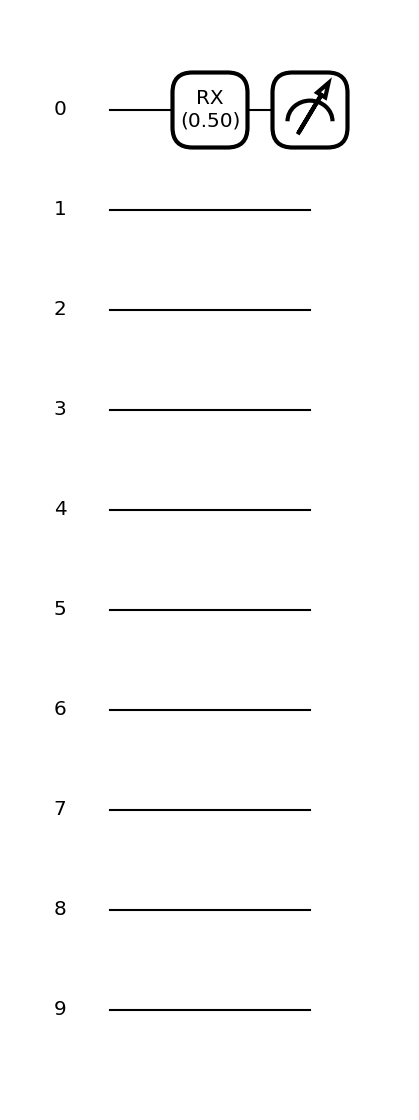

In [19]:
w = np.random.random(size=(n_layers, n_qubits))
fig, ax = qml.draw_mpl(qnode, show_all_wires=True, decimals=2, fontsize="x-large")(0.5)
fig.show()

In [34]:
print(qml.draw(qnode, expansion_strategy="device")(w,w))

0: ──H──RY(M0)──RZ(M0)──RY(M0)──RY(M0)──RZ(M0)──RY(M0)──H──RY(0.06)──RY(0.69)──RY(0.67)──RY(0.55)
1: ──H──RY(M1)──RZ(M1)──RY(M1)──RY(M1)──RZ(M1)──RY(M1)──H──RY(0.60)──RY(0.64)──RY(0.09)──RY(0.97)
2: ──H──RY(M2)──RZ(M2)──RY(M2)──RY(M2)──RZ(M2)──RY(M2)──H──RY(0.35)──RY(0.58)──RY(0.25)──RY(0.38)
3: ──H──RY(M3)──RZ(M3)──RY(M3)──RY(M3)──RZ(M3)──RY(M3)──H──RY(0.68)──RY(0.08)──RY(0.67)──RY(0.90)
4: ──H──RY(M4)──RZ(M4)──RY(M4)──RY(M4)──RZ(M4)──RY(M4)──H──RY(0.03)──RY(0.33)──RY(0.58)──RY(0.48)
5: ──H──RY(M5)──RZ(M5)──RY(M5)──RY(M5)──RZ(M5)──RY(M5)──H──RY(0.72)──RY(0.31)──RY(0.31)──RY(0.73)
6: ──H──RY(M6)──RZ(M6)──RY(M6)──RY(M6)──RZ(M6)──RY(M6)──H──RY(0.75)──RY(0.11)──RY(0.79)──RY(0.39)
7: ──H──RY(M7)──RZ(M7)──RY(M7)──RY(M7)──RZ(M7)──RY(M7)──H──RY(0.53)──RY(0.99)──RY(0.09)──────────
8: ──H──RY(M8)──RZ(M8)──RY(M8)──RY(M8)──RZ(M8)──RY(M8)──H──RY(0.91)──RY(0.91)──RY(0.50)──RY(0.81)
9: ──H──RY(M9)──RZ(M9)──RY(M9)──RY(M9)──RZ(M9)──RY(M9)──H──RY(0.39)──RY(0.80)──RY(0.51)──RY(0.31)

───────────────────

In [61]:

import jax_metrics as jm

loss_func = jm.losses.Crossentropy()

In [55]:
opt = optax.adam(learning_rate=0.3)

In [73]:
class HybridModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.clayer_1 = torch.nn.Linear(2, 20)
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_2 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.clayer_2 = torch.nn.Linear(20, 2)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.clayer_1(x)
        x_1, x_2 = torch.split(x, 10, dim=1)
        x_1 = self.qlayer_1(x_1)
        x_2 = self.qlayer_2(x_2)
        x = torch.cat([x_1, x_2], axis=1)
        x = self.clayer_2(x)
        return self.softmax(x)

model = HybridModel()

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
from matplotlib.colors import ListedColormap
h=0.2
cm = plt.cm.RdBu                           # Test point colors
cm_bright = ListedColormap(['#FF0000', '#0000FF']) # Train point colors

In [80]:
figure_main = plt.figure("main",figsize=(4 * (2 + 1), 4 * 2))
#X = torch.tensor(X, requires_grad=True).float()
#X = X.detach().numpy()
y_hot = y_hot.float()

batch_size = 5
batches = 200 // batch_size

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=149)
# Convert data to PyTorch tensors
#X_train = torch.tensor(X_train, requires_grad=True).float()
# y_ = torch.unsqueeze(torch.tensor(y_train), 1)  # used for one-hot encoded labels
# y_train_hot = torch.scatter(torch.zeros((280, 2)), 1, y_, 1)
y_train_hot = digits2position(y_train, 2)

#X_test = torch.tensor(X_test, requires_grad=True).float()
# y_ = torch.unsqueeze(torch.tensor(y_test), 1)  # used for one-hot encoded labels
# y_test_hot = torch.scatter(torch.zeros((120, 2)), 1, y_, 1)
# y_test_hot = y_test_hot.float()
y_test_hot = digits2position(y_test, 2)

# plot settings
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

train_dataset = TensorDataset(X_train, y_train_hot)
test_dataset = TensorDataset(X_test, y_test_hot)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True, drop_last=True)

X_train = X_train.detach().numpy()
X_test = X_test.detach().numpy()

# plot the training dataset
ax = plt.subplot(2, 2 + 1, 1)
# plot training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
        edgecolors='k', alpha=0.1)

# Plot test points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
        edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

opt = torch.optim.Adam(model.parameters(), lr=0.0004)

train_acc_history = []
test_acc_history = []

# iterate
grid_points = np.c_[xx.ravel(), yy.ravel()]

epochs = 1

for epoch in range(epochs):
    train_running_loss = 0
    test_running_loss = 0
    for xs, ys in train_loader:
        opt.zero_grad()
        
        loss_evaluated = loss_func(preds=model(xs), target=ys)
        loss_evaluated.backward()

        opt.step()

        train_running_loss += loss_evaluated.item()
        
    train_avg_loss = train_running_loss / batches

    print(f"Train - Epoch {epoch + 1}: Loss: {train_avg_loss:.4f}")
    
    X_train = torch.tensor(X_train, requires_grad=True).float()
    # Calculate train accuracy
    y_pred_train = model(X_train)
    predictions_train = torch.argmax(y_pred_train, axis=1).detach().numpy()

    correct_train = [1 if p == p_true else 0 for p, p_true in zip(predictions_train, y_train)]
    train_accuracy = sum(correct_train) / len(correct_train)
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    train_acc_history.append(train_accuracy)
    
    # Calculate testmodel.eval()
    with torch.no_grad():
        X_test = torch.tensor(X_test, requires_grad=True).float()
        y_pred_test = model(X_test)
        predictions_test = torch.argmax(y_pred_test, axis=1).detach().numpy()
        correct_test = [1 if p == p_true else 0 for p, p_true in zip(predictions_test, y_test)]
        test_accuracy = sum(correct_test) / len(correct_test)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
        test_acc_history.append(test_accuracy)
        
    # In order to draw the decision border we 
    # compute predictions for the whole 2D plane.

    grid_points = torch.tensor(grid_points, requires_grad=True).float()
    grid_results = model(grid_points).detach().numpy()
    Z = np.tanh(grid_results[:, 1] - grid_results[:, 0])
    Z = Z.reshape(xx.shape)

    # Add subplot to the main figure.
    ax = plt.subplot(2, 2 + 1, 2)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    X_train = X_train.detach().numpy()
    X_test = X_test.detach().numpy()
    # Plot training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
            edgecolors='k', alpha=0.1)
    
    # Plot test points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
            edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

TypeError: 'int' object is not callable

<Figure size 1200x800 with 0 Axes>

In [39]:
figure_main.savefig('my_figure.png', dpi=300)

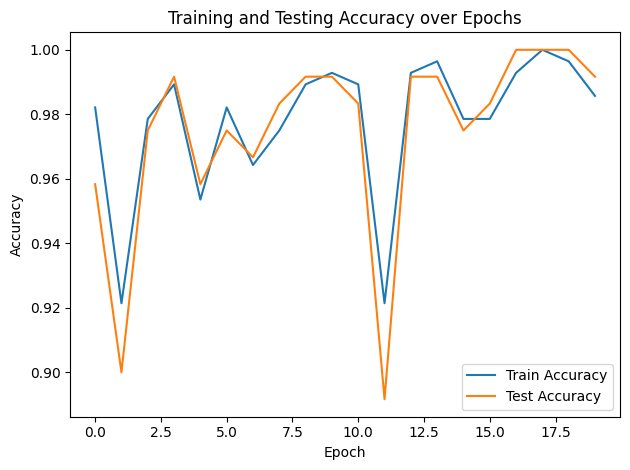

In [88]:
# Plotting the training and testing accuracies
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy over Epochs')
plt.tight_layout()
plt.show()

In [9]:
seconds = time.time()
print("Time in seconds since end of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since end of run: 1708813854.662059
Sat Feb 24 15:30:54 2024
